In [43]:
import pandas as pd
import numpy as np
#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)
import time
import os
from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.utils import class_weight
#for deep learning
import tensorflow.keras
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical

In [44]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names
    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10',
                    'SensorMeasure14', 'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']
    df_train = pd.read_csv('data/CMaps/train_FD001.txt',delim_whitespace=True,names=input_file_column_names)
    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)
    df_train['failure_lbl_1'] = [1 if i < 50 else 0 for i in df_train.RUL]
    df_train['failure_lbl_2'] = df_train['failure_lbl_1']
    df_train['failure_lbl_2']=np.where(df_train.RUL < 25, 2, df_train['failure_lbl_2'])
    df_test = pd.read_csv('data/CMaps/test_FD001.txt', delim_whitespace=True, names=input_file_column_names)    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)
    y_true = pd.read_csv('data/CMaps/RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    y_true['failure_lbl_1'] = [1 if i < 50 else 0 for i in y_true.RUL]
    y_true['failure_lbl_2'] = y_true['failure_lbl_1']
    y_true['failure_lbl_2'] = np.where(y_true.RUL < 25, 2, y_true['failure_lbl_2'])    
    return df_train, df_test, y_true

In [45]:
df_train, df_test, y_true = prepare_data(drop_cols=True)
df_train.shape, df_test.shape, y_true.shape

((20631, 20), (13096, 17), (100, 4))

In [46]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL', 'failure_lbl_1', 'failure_lbl_2'])

In [47]:

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [48]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL,failure_lbl_1,failure_lbl_2
0,1,1,-0.080460,-0.666667,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.272028,-0.333333,0.426357,0.449323,191,0,0
1,1,2,0.218391,-0.500000,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.177376,-0.333333,0.333333,0.462027,190,0,0
2,1,3,-0.494253,0.500000,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.285110,-0.666667,0.255814,0.242751,189,0,0
3,1,4,0.080460,0.000000,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.666795,-0.333333,0.147287,0.324772,188,0,0
4,1,5,-0.218391,-0.333333,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.195845,-0.166667,0.178295,0.409003,187,0,0


In [49]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.398230,-0.666667,0.317829,0.432753


In [50]:
y_true.head()

,RUL,UnitNumber,failure_lbl_1,failure_lbl_2
0,112,0,0,0
1,98,1,0,0
2,69,2,0,0
3,82,3,0,0
4,91,4,0,0


In [51]:
def gen_train(id_df, seq_length, seq_cols):
    """
        repeated overlay of chunks of size seq_length to prepare (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)

In [52]:
def gen_target(id_df, seq_length, label):
    # label is the column name string for target
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [53]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value    
    id_df1 = pd.concat([df_mask, id_df],ignore_index=True)    
    data_array = id_df1[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    start = num_elements-seq_length
    stop = num_elements    
    lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)

In [54]:
def print_results(y_test, y_pred, multi_class = False):    
    #f1-score
    if multi_class == True:
        f1 = f1_score(y_test, y_pred, average="macro")
    else:
        f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_test, y_pred))    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt="d", annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    #roc_auc_score
    if multi_class == False:
        model_roc_auc = roc_auc_score(y_test, y_pred) 
        print ("Area Under Curve : ", model_roc_auc, "\n")
        fpr,tpr,thresholds = roc_curve(y_test, y_pred)
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        threshold = np.round(thresholds[ix],3)
        plt.subplot(222)
        plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")

In [55]:
sequence_length = 50
mask_value = 0
label = "failure_lbl_1"

In [56]:
#generate train
train1 = gen_train(df_train[df_train['UnitNumber']==1], sequence_length, feats)
print(train1.shape)
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(143, 50, 15)
(15731, 50, 15)


In [57]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, label)) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [58]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [59]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [60]:
nb_features = x_train.shape[2]
nb_out = 1

In [61]:
nb_features

15

In [62]:
cls_wt= class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
cls_wt = {i : cls_wt[i] for i in range(2)}
cls_wt

{0: 0.7329699002888826, 1: 1.5731}

In [63]:
history = History()
model = Sequential()
model.add(Conv1D(64, 4, activation = 'relu', input_shape=(sequence_length, nb_features)))
model.add(Conv1D(64, 4, activation='relu'))
model.add(Conv1D(64, 4, activation='relu'))
model.add(Conv1D(64, 4, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 47, 64)            3904      
                                                                 
 conv1d_8 (Conv1D)           (None, 44, 64)            16448     
                                                                 
 conv1d_9 (Conv1D)           (None, 41, 64)            16448     
                                                                 
 conv1d_10 (Conv1D)          (None, 38, 64)            16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 12, 64)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 10, 128)           24704     
                                                      

In [64]:
%%time
# fit the model
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1, class_weight=cls_wt,
          callbacks=[history, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3,
                                                      verbose=0, mode='auto')])

Epoch 1/10
222/222 [==============================] - 8s 31ms/step - loss: 0.3135 - accuracy: 0.8808 - val_loss: 0.2499 - val_accuracy: 0.8825
Epoch 2/10
222/222 [==============================] - 15s 68ms/step - loss: 0.1687 - accuracy: 0.9433 - val_loss: 0.1971 - val_accuracy: 0.9130
Epoch 3/10
222/222 [==============================] - 31s 141ms/step - loss: 0.0867 - accuracy: 0.9681 - val_loss: 0.3411 - val_accuracy: 0.9130
Epoch 4/10
222/222 [==============================] - 23s 101ms/step - loss: 0.0444 - accuracy: 0.9828 - val_loss: 0.4013 - val_accuracy: 0.8920
Epoch 5/10
222/222 [==============================] - 17s 78ms/step - loss: 0.0368 - accuracy: 0.9865 - val_loss: 0.3554 - val_accuracy: 0.9009
CPU times: total: 10min 19s
Wall time: 1min 34s


Text(0.5, 1.0, 'Loss')

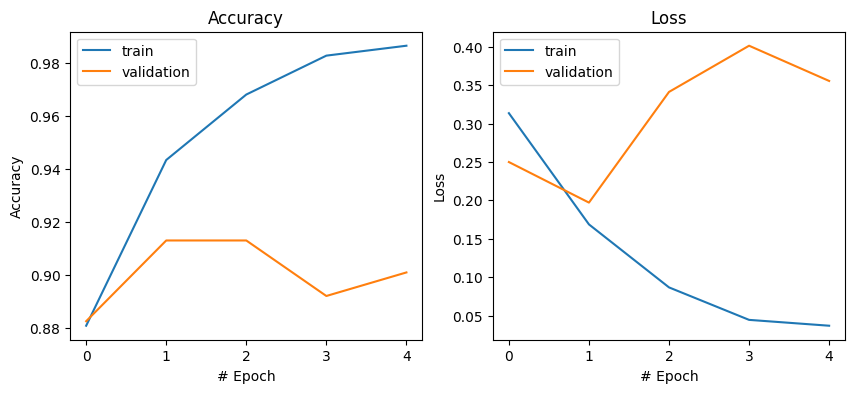

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

In [67]:
y_train

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

4/4 [==============================] - 0s 6ms/step
F1 Score:  0.9354838709677419
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        70
           1       0.91      0.97      0.94        30

    accuracy                           0.96       100
   macro avg       0.95      0.96      0.95       100
weighted avg       0.96      0.96      0.96       100

Area Under Curve :  0.9619047619047619 



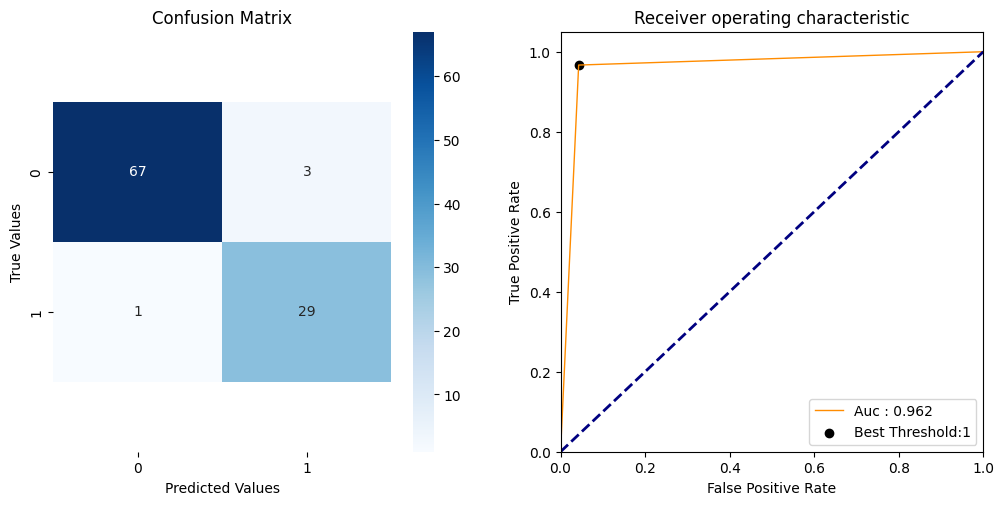

In [68]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print_results(y_true.failure_lbl_1, y_pred)

In [69]:
confusion_matrix(y_train, (model.predict(x_train) > 0.5).astype("int32"))

492/492 [==============================] - 1s 2ms/step


array([[10352,   379],
       [   23,  4977]], dtype=int64)

In [70]:
sequence_length = 50
mask_value = 0
label = "failure_lbl_2"

In [71]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [72]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, label)) for unit in df_train['UnitNumber'].unique()))
print(y_train.shape)
y_train

(15731,)


array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

In [73]:
y_train

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

In [74]:
# vectorize y_train
y_train2 = to_categorical(y_train)
y_train2

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [75]:
y_train2

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [76]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [77]:
nb_features = x_train.shape[2]
nb_out = 1

In [78]:
nb_features

15

In [79]:
cls_wt= class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train), y=y_train)
cls_wt = {i : cls_wt[i] for i in range(3)}
cls_wt

{0: 0.48864660019258843, 1: 2.0974666666666666, 2: 2.0974666666666666}

In [80]:
history2 = History()
model2 = Sequential()
model2.add(Conv1D(64, 6, activation = 'relu', input_shape=(sequence_length, nb_features)))
model2.add(Conv1D(64, 6, activation='relu'))
model2.add(Conv1D(64, 6, activation='relu'))
model2.add(Conv1D(64, 6, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(Conv1D(128, 4, activation='relu'))
model2.add(Conv1D(128, 4, activation='relu'))
model2.add(Conv1D(128, 4, activation='relu'))
model2.add(MaxPooling1D(1))
model2.add(Conv1D(256, 2, activation='relu'))
model2.add(Conv1D(256, 2, activation='relu'))
model2.add(GlobalAveragePooling1D())
model2.add(Dropout(0.5))
model2.add(Dense(units=3, activation='softmax'))
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 45, 64)            5824      
                                                                 
 conv1d_15 (Conv1D)          (None, 40, 64)            24640     
                                                                 
 conv1d_16 (Conv1D)          (None, 35, 64)            24640     
                                                                 
 conv1d_17 (Conv1D)          (None, 30, 64)            24640     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 15, 64)           0         
 1D)                                                             
                                                                 
 conv1d_18 (Conv1D)          (None, 12, 128)           32896     
                                                      

In [82]:
%%time
# fit the model
model2.fit(x_train, y_train2, epochs=10, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
           callbacks=[history2, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')])

Epoch 1/10
222/222 [==============================] - 17s 72ms/step - loss: 0.5649 - accuracy: 0.8062 - val_loss: 0.4055 - val_accuracy: 0.8335
Epoch 2/10
222/222 [==============================] - 15s 68ms/step - loss: 0.3204 - accuracy: 0.8851 - val_loss: 0.2789 - val_accuracy: 0.8761
Epoch 3/10
222/222 [==============================] - 8s 38ms/step - loss: 0.2004 - accuracy: 0.9350 - val_loss: 0.3493 - val_accuracy: 0.8767
Epoch 4/10
222/222 [==============================] - 15s 70ms/step - loss: 0.1313 - accuracy: 0.9543 - val_loss: 0.6422 - val_accuracy: 0.8482
Epoch 5/10
222/222 [==============================] - 17s 75ms/step - loss: 0.1142 - accuracy: 0.9611 - val_loss: 0.5179 - val_accuracy: 0.8812
CPU times: total: 8min 23s
Wall time: 1min 13s


Text(0.5, 1.0, 'Loss')

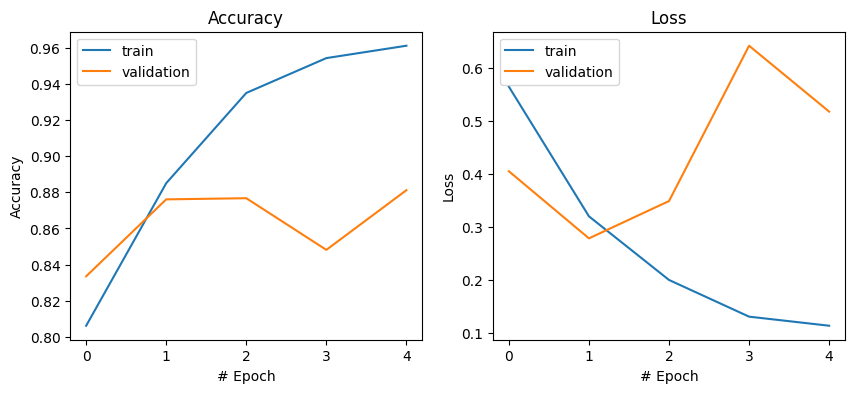

In [83]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
# Accuracy
ax[0].plot(history2.history['accuracy'])
ax[0].plot(history2.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history2.history['loss'])
ax[1].plot(history2.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

4/4 [==============================] - 0s 8ms/step
F1 Score:  0.7674967718133185
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        70
           1       0.47      0.64      0.54        11
           2       0.88      0.74      0.80        19

    accuracy                           0.88       100
   macro avg       0.77      0.78      0.77       100
weighted avg       0.90      0.88      0.89       100



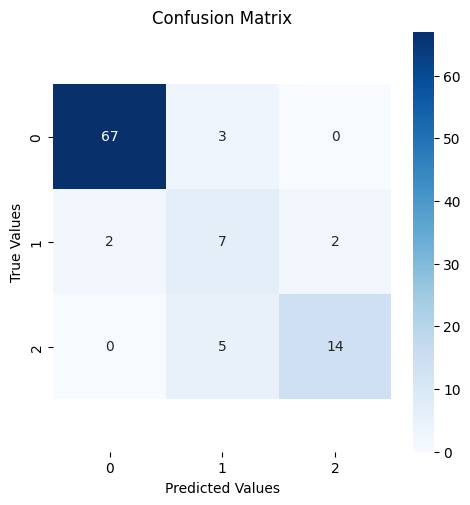

In [84]:
y_pred = np.argmax(model2.predict(x_test), axis=-1)
print_results(y_true.failure_lbl_2, y_pred, multi_class=True)

In [85]:
confusion_matrix(y_train, np.argmax(model2.predict(x_train), axis=-1))

492/492 [==============================] - 2s 3ms/step


array([[10599,   132,     0],
       [   70,  2300,   130],
       [    0,    75,  2425]], dtype=int64)

In [87]:
x_train.shape

(15731, 50, 15)

In [88]:
y_train.shape

(15731,)